In [1]:
import os, random, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
import matplotlib.pyplot as plt
import utils  # your local utils.py

from sklearn.utils import class_weight
from keras_tuner import RandomSearch
from datetime import datetime


In [2]:

SEED = 424
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

mixed_precision.set_global_policy('mixed_float16')

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

tf.config.optimizer.set_jit(False)


In [3]:

TRAIN_CSV = "./split_data/train.csv"
VAL_CSV = "./split_data/val.csv"
TEST_CSV = "./split_data/test.csv"
BATCH = 8
IMG_SIZE = 128
autotune = True

train_paths, train_labels, le = utils.load_paths_and_labels(TRAIN_CSV)
val_paths, val_labels = utils.encode(VAL_CSV, le)
test_paths, test_labels = utils.encode(TEST_CSV, le)

utils.show_dataset_class_distribution("TRAIN", train_labels)
utils.show_dataset_class_distribution("VAL  ", val_labels)
utils.show_dataset_class_distribution("TEST ", test_labels)


TRAIN {np.int64(0): 276, np.int64(1): 246, np.int64(2): 252, np.int64(3): 474, np.int64(4): 297, np.int64(5): 300, np.int64(6): 552, np.int64(7): 190, np.int64(8): 261}  (total: 2848)
VAL   {np.int64(0): 92, np.int64(1): 82, np.int64(2): 84, np.int64(3): 158, np.int64(4): 99, np.int64(5): 100, np.int64(6): 184, np.int64(7): 64, np.int64(8): 87}  (total: 950)
TEST  {np.int64(0): 93, np.int64(1): 83, np.int64(2): 84, np.int64(3): 158, np.int64(4): 99, np.int64(5): 100, np.int64(6): 185, np.int64(7): 64, np.int64(8): 88}  (total: 954)


c:\Users\user\MLProject\utils.py:176: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Saved → batch.png


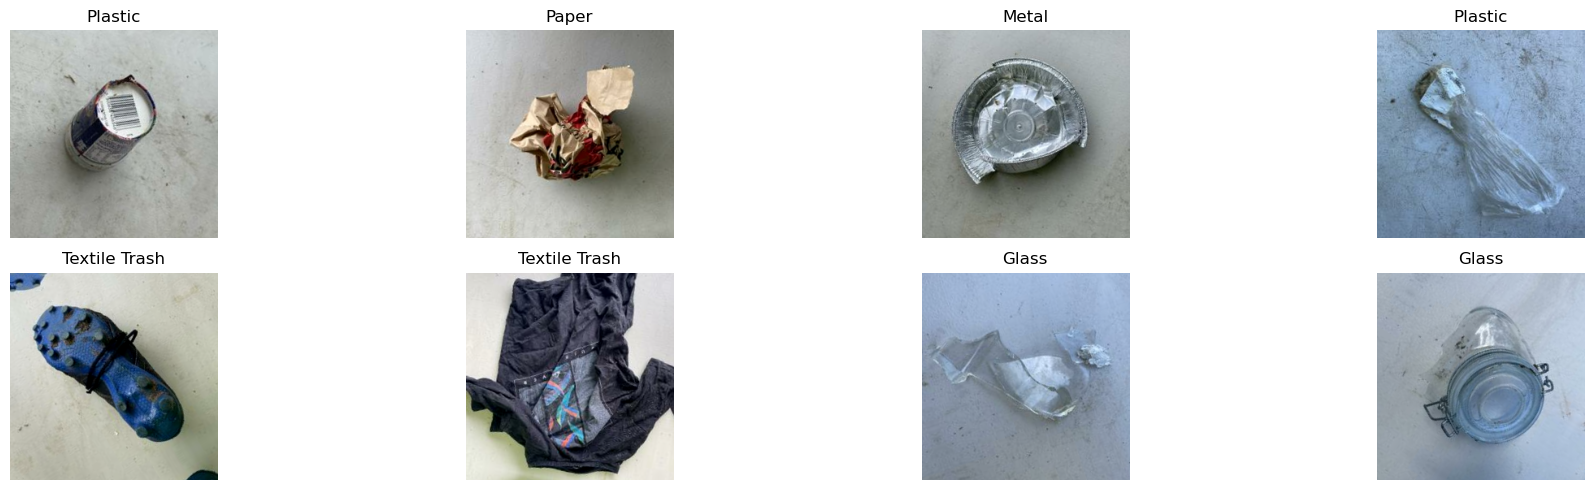

In [4]:

augment_layer = utils.make_augment()

train_ds = utils.make_dataset(train_paths, train_labels, BATCH, shuffle=True, autotune=autotune)
train_ds = train_ds.map(
    lambda imgs, labs: (augment_layer(imgs, training=True), labs),
    num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

val_ds = utils.make_dataset(val_paths, val_labels, BATCH, shuffle=True, autotune=autotune)
test_ds = utils.make_dataset(test_paths, test_labels, BATCH, shuffle=False, autotune=autotune)

utils.show_image_of_batch(train_ds, le)


In [5]:

cw_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_w = dict(enumerate(cw_vals))
print(class_w)


{0: np.float64(1.146537842190016), 1: np.float64(1.2863595302619693), 2: np.float64(1.255731922398589), 3: np.float64(0.6676043131739334), 4: np.float64(1.0654695099139544), 5: np.float64(1.0548148148148149), 6: np.float64(0.573268921095008), 7: np.float64(1.6654970760233918), 8: np.float64(1.2124308216262238)}


In [6]:

def sparse_focal_loss(gamma=2.0, alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int64)
        batch_idxs = tf.range(tf.shape(y_pred)[0], dtype=y_true.dtype)
        indices = tf.stack([batch_idxs, y_true], axis=1)
        p_t = tf.gather_nd(y_pred, indices)
        alpha_factor = tf.where(tf.equal(y_true, 0), 1.0 - alpha, alpha)
        focal_weight = alpha_factor * tf.pow(1.0 - p_t, gamma)
        loss = -focal_weight * tf.math.log(tf.clip_by_value(p_t, 1e-8, 1.0))
        return tf.reduce_mean(loss)
    return loss_fn


In [7]:

def build_model(hp):
    filters = hp.Choice("filters", values=[32, 64, 128], default=64)
    dense_units = hp.Int("dense_units", min_value=64, max_value=512, step=64)

    model = keras.Sequential([
        keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Conv2D(filters, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(filters//2, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(filters//4, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(dense_units, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(len(le.classes_), activation='softmax', dtype='float32')
    ])

    lr = hp.Choice("lr", values=[1e-4, 3e-4, 1e-3], default=1e-4)
    model.compile(optimizer=keras.optimizers.Adam(lr),
                  loss=sparse_focal_loss(),
                  metrics=["accuracy"])
    return model


In [8]:

tuner = RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="trashnet_tune"
)


In [9]:

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_w,
    callbacks=[tensorboard_cb]
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |filters
256               |256               |dense_units
0.0003            |0.0003            |lr

Epoch 1/10
 16/356 ━━━━━━━━━━━━━━━━━━━━ 9:18 2s/step - accuracy: 0.1549 - loss: 0.8007

KeyboardInterrupt: 

In [ ]:

best_hp = tuner.get_best_hyperparameters()[0]
print("Best hyperparameters:", best_hp.values)

model = tuner.hypermodel.build(best_hp)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_w,
    callbacks=[
        tensorboard_cb,
        utils.ConfusionMatrixSaver(val_ds, le.classes_, every=3),
        utils.checkpoint_cb(),
        utils.csv_logger_cb()
    ]
)


In [ ]:

%load_ext tensorboard
%tensorboard --logdir logs/fit
